In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os, glob
from astropy.io import ascii 
from astropy.stats import sigma_clip

In [2]:
def plot_lc(df, ax=None, errorbars=True, **kwargs):
    
    time_corr = df['HJD'] - 2450000 # transform HDJ date
    
    ax = ax or plt.gca()
    
    if errorbars==True:
        ax.errorbar(time_corr, df['flux'], df['flux_err'], fmt='.', **kwargs)
    else:
        ax.plot(time_corr, df['flux'],'.', **kwargs)
  
    ax.set_ylabel('Flux')
    ax.set_xlabel('HJD - 2450000')
    ax.grid()
    return ax
def resample(df_in, t_bin=1.):
    '''
    Given a light curve DataFrame, resample the data into bins of size "t_bin" 
    It applies astropy's sigma_clip to the flux

    Parameters
    ----------
    df_in : DataFrame
        light curve data.
    t_bin : integer
        Bin size in days.
    eclipse: Boolean
        True to resample eclipse or False to skip in-eclipse points

    Returns
    -------
    df_rs : DataFrame
        Resampled light curve.
    '''
    print('------> Rebinning light curve to {:}-day bins'.format(int(t_bin)))
    print('Number of points RAW light curve...', len(df_in))
    df_in = df_in.sort_values('HJD') # important for next step
    
    t_rebin = np.arange(df_in['HJD'].iloc[0], df_in['HJD'].iloc[-1], t_bin)
    time, flux, flux_err, boxes = ([] for i in range(4))
    for t in t_rebin:
        start = t - t_bin/2.
        end = t + t_bin/2.
        boxes.append((start, end)) # only for displaying-purposes
        
        df = df_in[(df_in['HJD'] > start) & (df_in['HJD'] < end)]
        if len(df) > 0:
            flux_clipped = sigma_clip(df['flux'], sigma=3, maxiters=2)
            meanflux = np.mean(flux_clipped)
            
            time.append(t)
            flux.append(meanflux)
            flux_err.append(np.std(flux_clipped))
            
    df_rs = pd.DataFrame(np.transpose([time, flux, flux_err]), columns=('HJD', 'flux', 'flux_err'))
    df_rs.insert(0, 'survey', df_in['survey'].iloc[0])

    print('Number of points RESAMPLED light curve...', len(df_rs))
    print('------> Done!')
    return df_rs

def pd_sigma(df, y='flux', n=1):
    '''
    Clip values "n"-sigma times beyond the mean on a given column "y"

    Parameters
    ----------
    df : DataFrame
        light curve data
    y : str, optional
        Column to be clipped. The default is 'mag_err'.
    n : int, optional
        Number of sigmas. The default is 1.

    Returns
    -------
    df : DataFrame
        Clipped dataframe.

    '''
    median = np.nanmedian(df[y])
    std = np.std(df[y])
    sigma = n*std
    df_clipped = df[abs(df[y] - median) < sigma]
    print('------> Sigma-clipping "{:}" values beyond {:}-sigma'.format(y, n))
    print('Number of points clipped... {:}'.format(len(df)-len(df_clipped)))
    return df_clipped

### Merged light curve

<IPython.core.display.Javascript object>


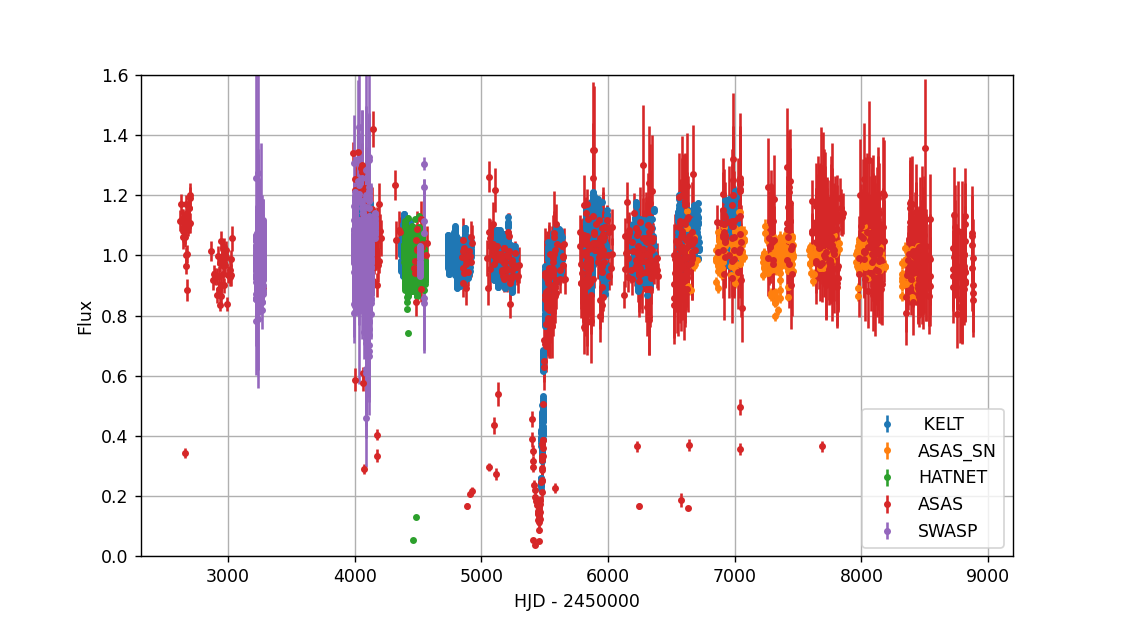

Plotting full light curve by survey


(0.0, 1.6)

In [3]:
%matplotlib notebook
df = pd.read_csv('v773tau_merged.csv')

df.insert(0,'eclipse','0') # out of eclipse "0"
df.loc[(df['HJD']>2455300)&(df['HJD']<2455500),'eclipse'] = 1 # in-eclipse "1"

fig, ax = plt.subplots(1, figsize=(9,5))
print('Plotting full light curve by survey')
for survey in df['survey'].unique():
    df_survey = df[df['survey']==survey]
    _ = plot_lc(df_survey, ax=ax, label=survey)
ax.legend()
ax.set_ylim(0.0, 1.60)

### Sigma-clipping on the full light curve

------> Sigma-clipping "flux" values beyond 3-sigma
Number of points clipped... 112


<IPython.core.display.Javascript object>


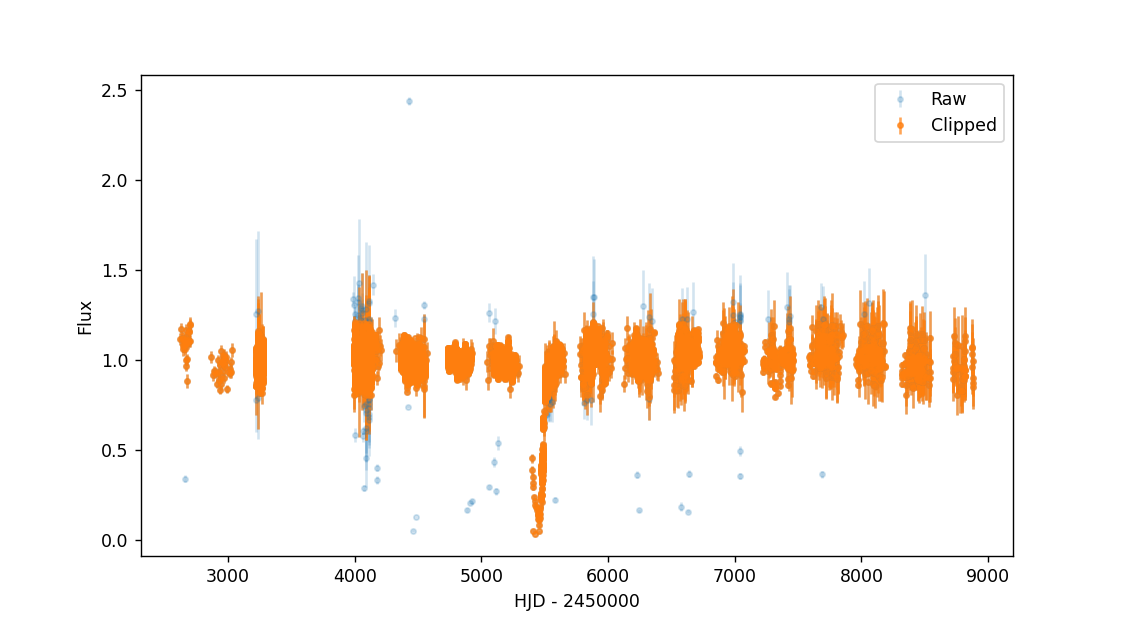

In [4]:
df_in, df_out = df[df['eclipse']==1], df[df['eclipse']!=1]
df_clipped = pd_sigma(df_out, y='flux', n=3)
df_clipped = pd.concat([df_in, df_clipped])

fig, ax = plt.subplots(1, figsize=(9,5))
_ = plot_lc(df, ax=ax, label='Raw', alpha=0.2)
_ = plot_lc(df_clipped, ax=ax, label='Clipped', alpha=0.7)
ax.legend()
df = df_clipped

### Rebinning KELT data

------> Rebinning light curve to 1-day bins
Number of points RAW light curve... 10269
Number of points RESAMPLED light curve... 647
------> Done!


<IPython.core.display.Javascript object>


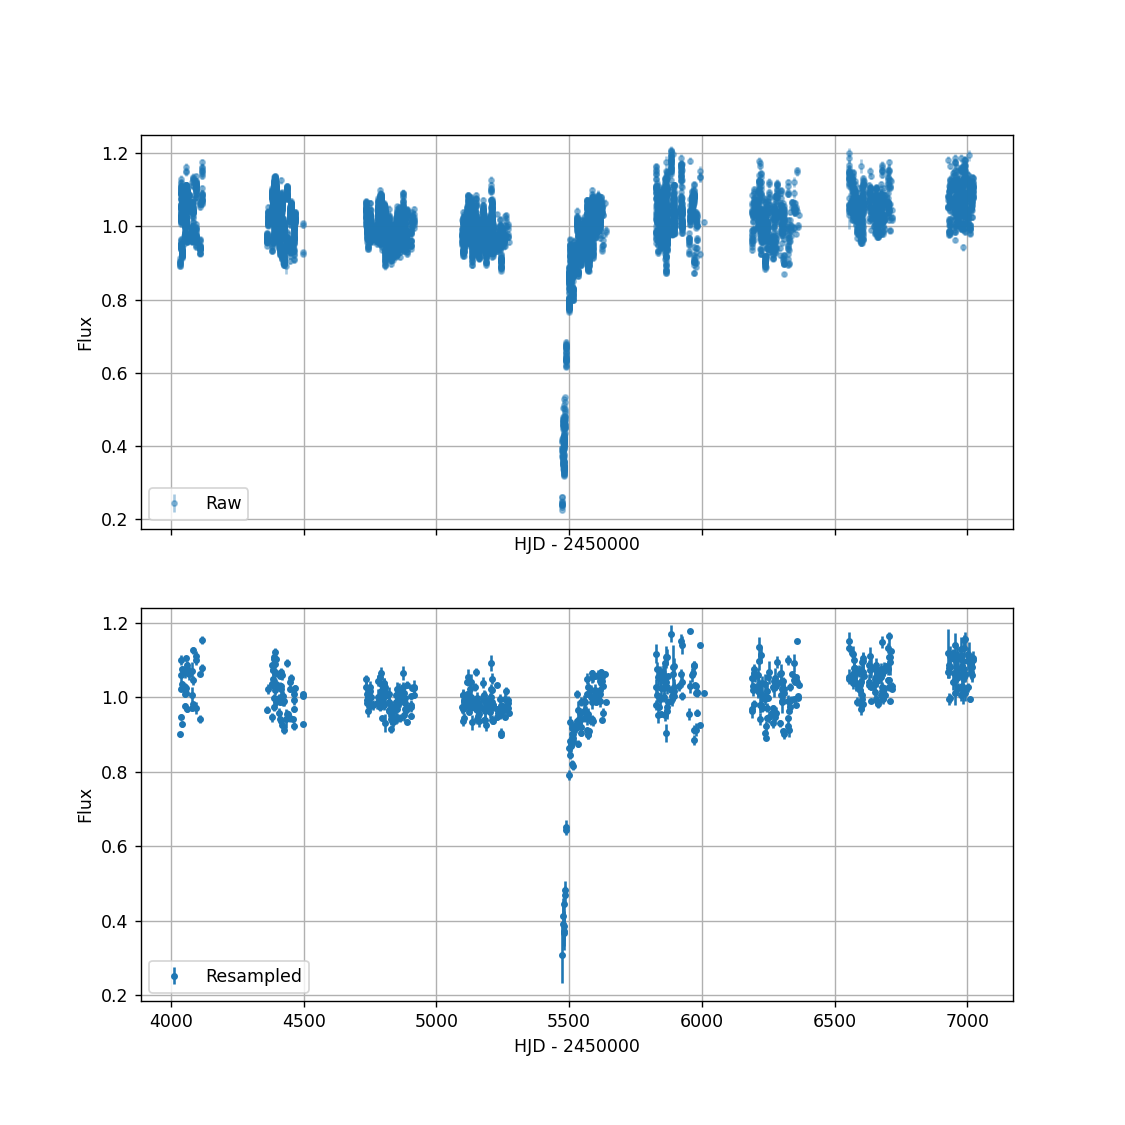

(0.17293975, 1.25)

In [5]:
df_kelt = df[df['survey']==' KELT'] # warning: there is an unwanted /s before "KELT"
# df_kelt_out = df_kelt[df_kelt['eclipse']!=1] # select only out of eclipse points
# df_kelt_rs = resample(df_kelt_out, t_bin=1.)
df_kelt_rs = resample(df_kelt, t_bin=1.)

# df_kelt_rs = pd.concat([df_kelt_rs, df_kelt[df_kelt['eclipse']==1]]) # merge with points in-eclipse

fig, ax = plt.subplots(2, figsize=(9,9), sharex=True)
_ = plot_lc(df_kelt, ax=ax[0], label='Raw', alpha=0.4)
_ = plot_lc(df_kelt_rs, ax=ax[1], label='Resampled')
ax[0].legend(), ax[1].legend()
ax[0].set_ylim(top=1.25)

### Rebinning ASASSN data

------> Rebinning light curve to 1-day bins
Number of points RAW light curve... 459
Number of points RESAMPLED light curve... 272
------> Done!


<IPython.core.display.Javascript object>


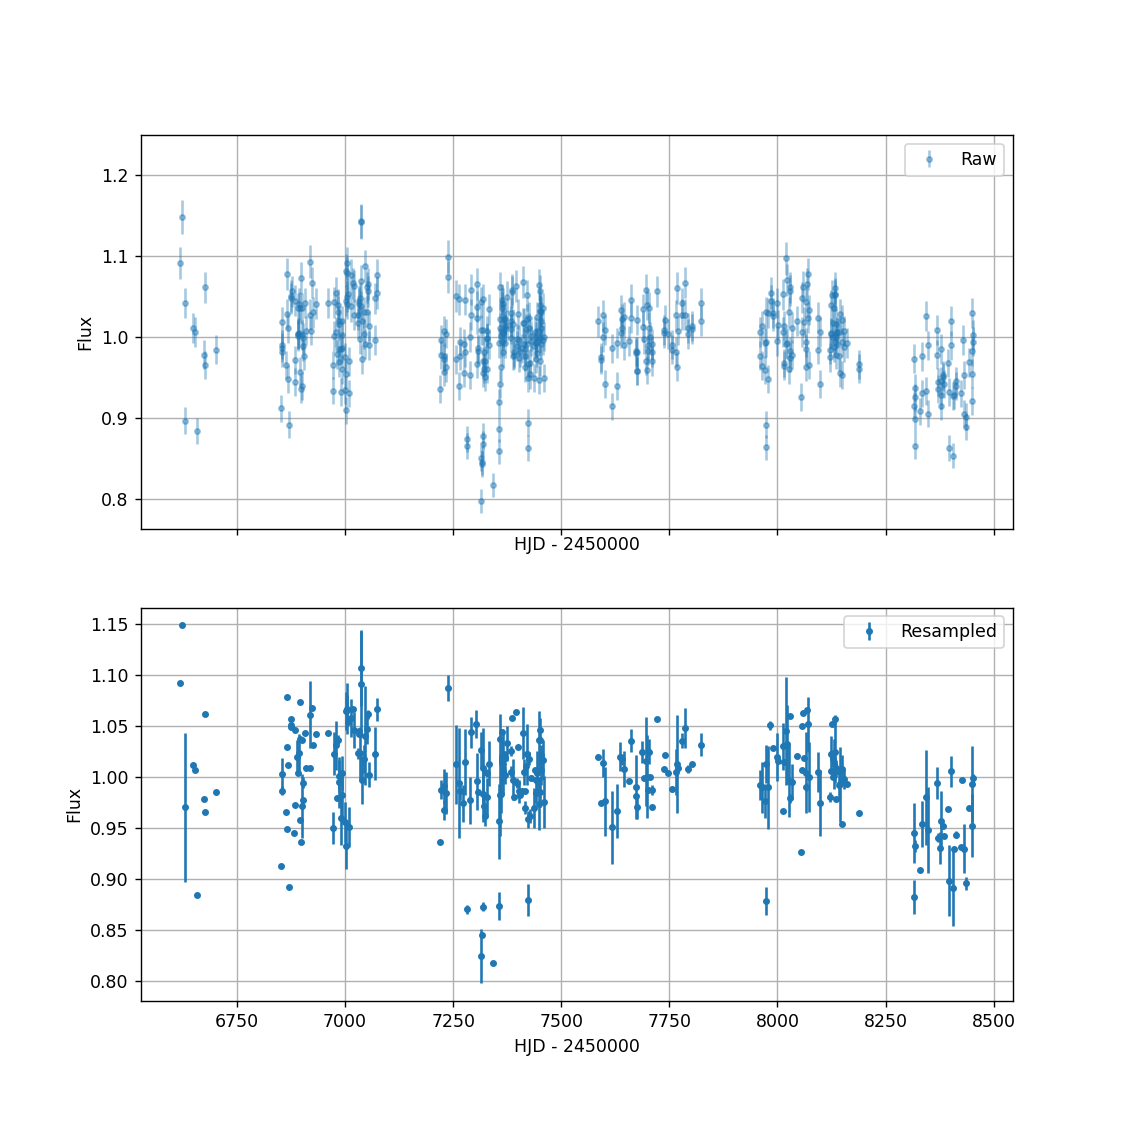

(0.7633015000000001, 1.25)

In [6]:
df_asassn = df[df['survey']=='ASAS_SN'] # warning: there is an unwanted /s before "asassn"
df_asassn_rs = resample(df_asassn, t_bin=1.)

fig, ax = plt.subplots(2, figsize=(9,9), sharex=True)
_ = plot_lc(df_asassn, ax=ax[0], label='Raw', alpha=0.4)
_ = plot_lc(df_asassn_rs, ax=ax[1], label='Resampled')
ax[0].legend(), ax[1].legend()
ax[0].set_ylim(top=1.25)

### Rebinning ASAS data

Skipping points in-eclipse for the resampling...
------> Rebinning light curve to 1-day bins
Number of points RAW light curve... 906
Number of points RESAMPLED light curve... 647
------> Done!


<IPython.core.display.Javascript object>


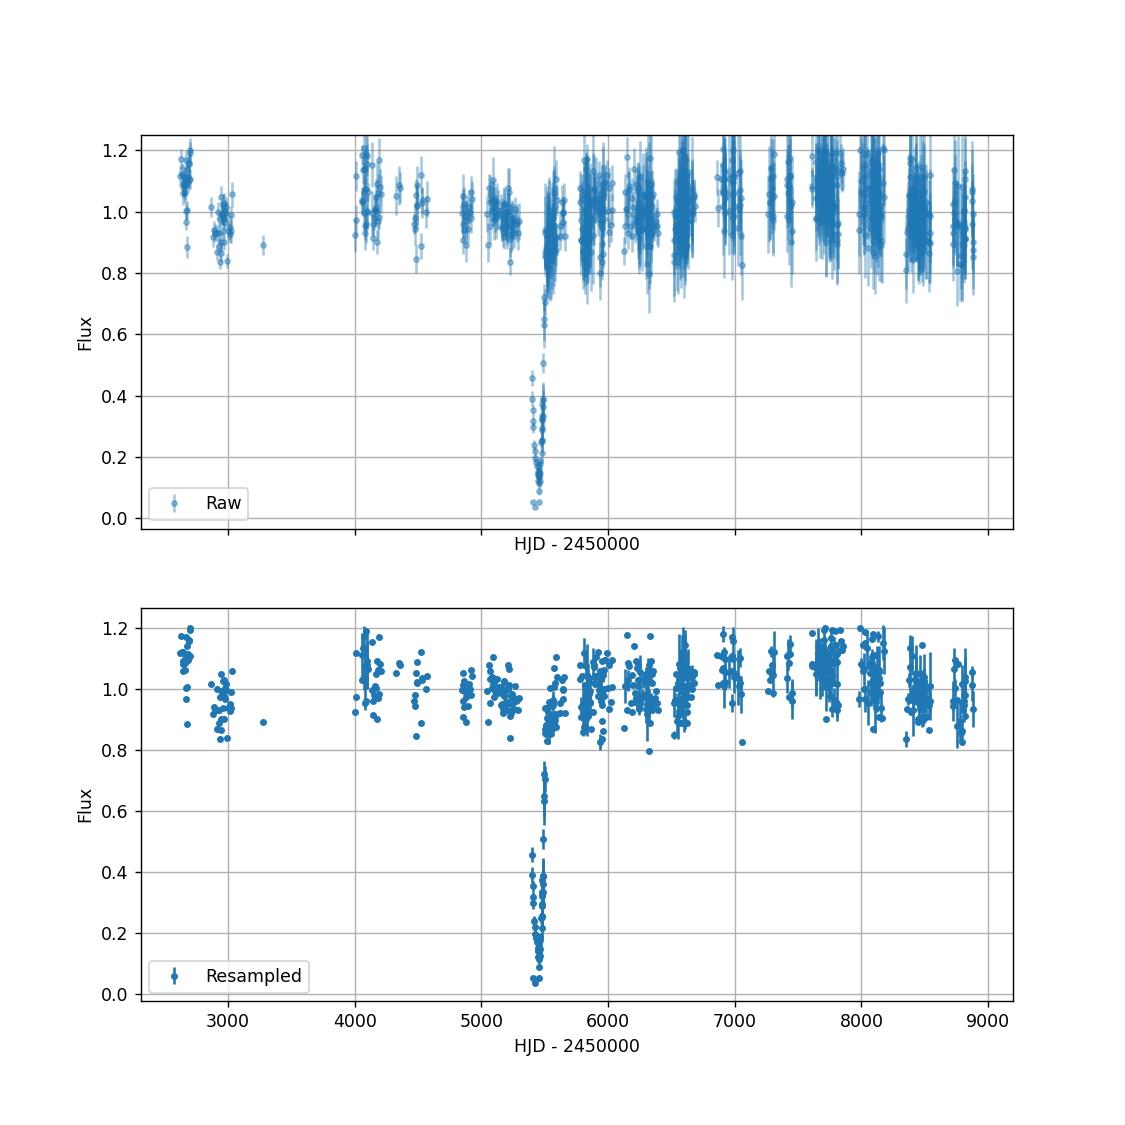

(-0.03447122488092077, 1.25)

In [7]:
df_asas = df[df['survey']=='ASAS'] # 

print('Skipping points in-eclipse for the resampling...')
df_asas_out = df_asas[df_asas['eclipse']!=1]

df_asas_rs = resample(df_asas_out, t_bin=1.)
df_asas_rs = pd.concat([df_asas_rs, df_asas[df_asas['eclipse']==1]])
#df_asas_rs = resample(df_asas, t_bin=1.)

fig, ax = plt.subplots(2, figsize=(9,9), sharex=True)
_ = plot_lc(df_asas, ax=ax[0], label='Raw', alpha=0.4)
_ = plot_lc(df_asas_rs, ax=ax[1], label='Resampled')
ax[0].legend(), ax[1].legend()
ax[0].set_ylim(top=1.25)

------> Rebinning light curve to 1-day bins
Number of points RAW light curve... 3399
Number of points RESAMPLED light curve... 87
------> Done!


<IPython.core.display.Javascript object>


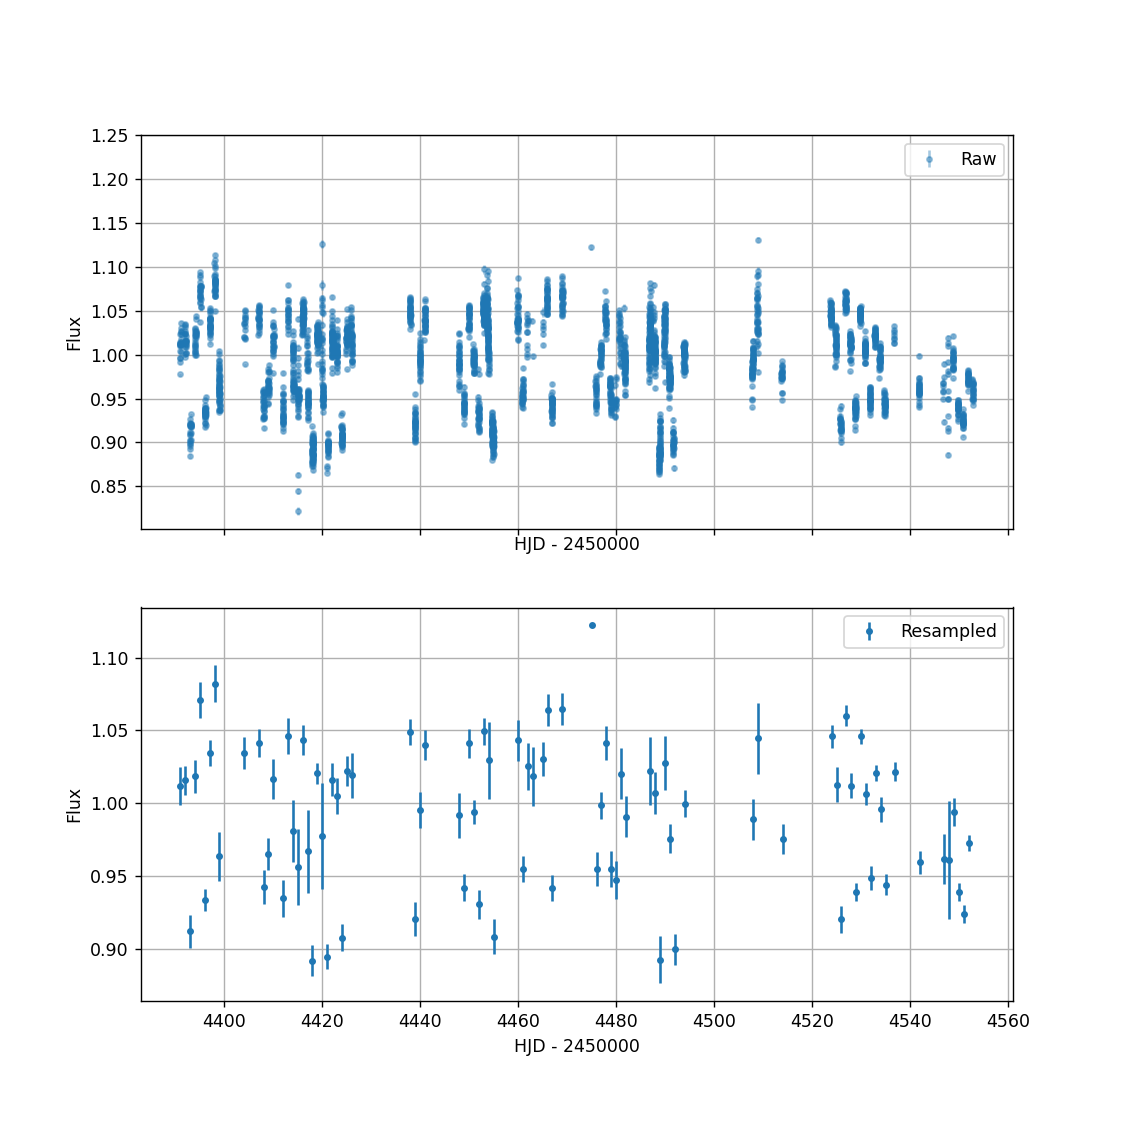

(0.8018043262893321, 1.25)

In [8]:
df_hat = df[df['survey']=='HATNET'] 
df_hat_rs = resample(df_hat)
fig, ax = plt.subplots(2, figsize=(9,9), sharex=True)
_ = plot_lc(df_hat, ax=ax[0], label='Raw', alpha=0.4)
_ = plot_lc(df_hat_rs, ax=ax[1], label='Resampled')
ax[0].legend(), ax[1].legend()
ax[0].set_ylim(top=1.25)

------> Rebinning light curve to 1-day bins
Number of points RAW light curve... 4597
Number of points RESAMPLED light curve... 104
------> Done!


<IPython.core.display.Javascript object>


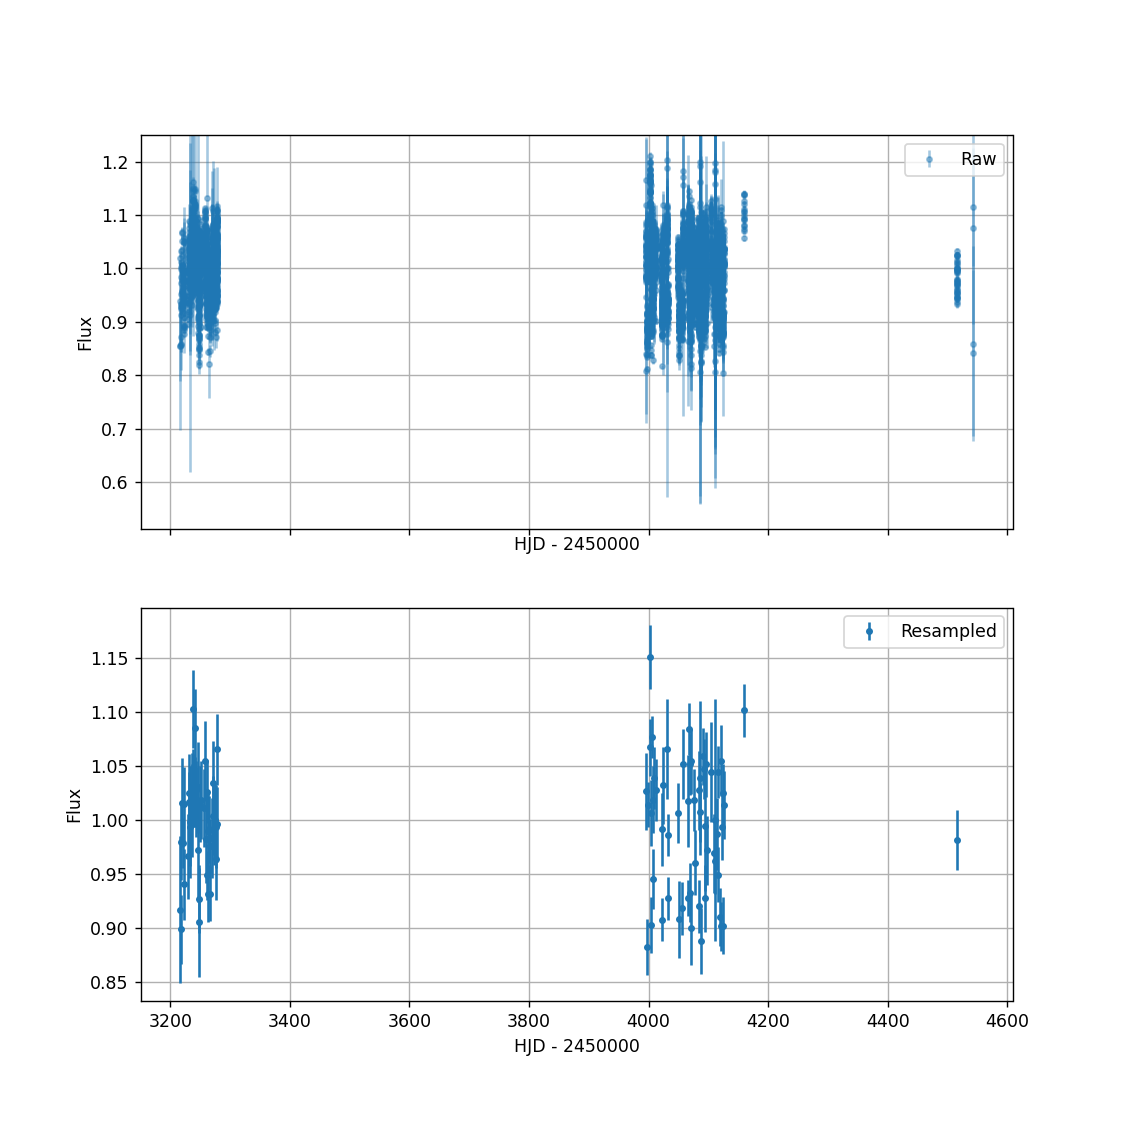

(0.512296118519161, 1.25)

In [9]:
df_swasp = df[df['survey']=='SWASP']
df_swasp_rs = resample(df_swasp)

fig, ax = plt.subplots(2, figsize=(9,9), sharex=True)
_ = plot_lc(df_swasp, ax=ax[0], label='Raw', alpha=0.4)
_ = plot_lc(df_swasp_rs, ax=ax[1], label='Resampled')
ax[0].legend(), ax[1].legend()
ax[0].set_ylim(top=1.25)

<IPython.core.display.Javascript object>


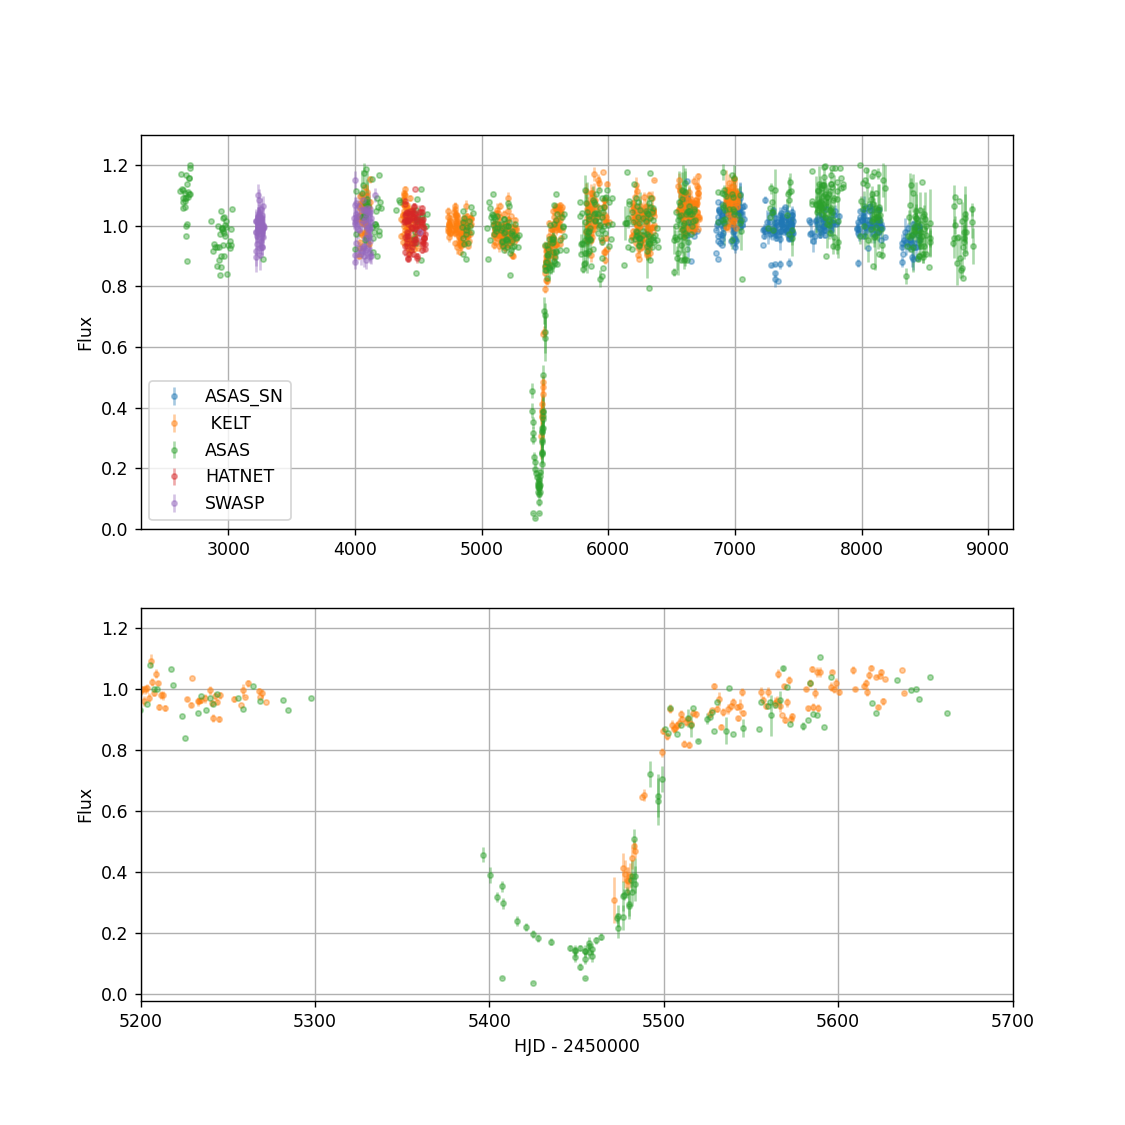

Plotting full light curve by survey


(0.0, 1.3)

In [24]:
df_full = pd.concat([df_asassn_rs, df_kelt_rs, df_asas_rs, df_hat_rs, df_swasp_rs], join='inner')
    
fig, (ax,ax1) = plt.subplots(2, figsize=(9,9))
print('Plotting full light curve by survey')
for survey in df_full['survey'].unique():
    df_full_survey = df_full[df_full['survey']==survey]
    _ = plot_lc(df_full_survey, ax=ax, label=survey, alpha=0.4)
    _ = plot_lc(df_full_survey, ax=ax1, label=survey, alpha=0.4) # zoomed-in
ax1.set_xlim(5200,5700)
ax.legend()
ax.set_xlabel(None)
ax.set_ylim(0.0, 1.30)    

### TESS data
TESS Optical 56624881 \
hlsp_qlp_tess_ffi_s0019-0000000056624881_tess_v01_llc.txt \
RA   04:14:12.923 \
DEC +28:12:12.38

<IPython.core.display.Javascript object>


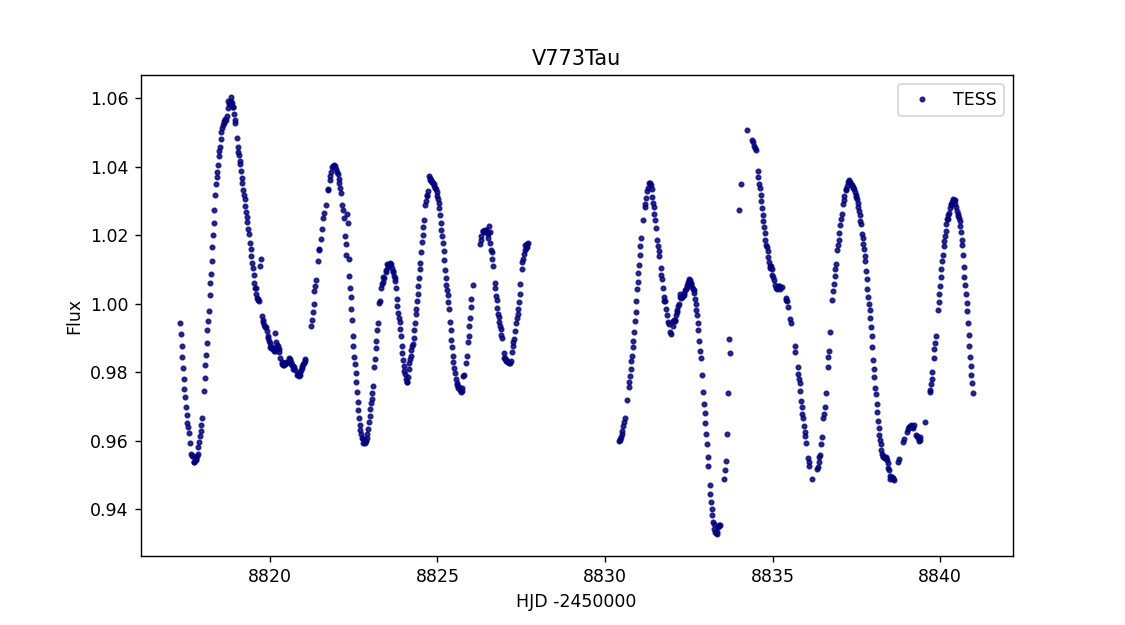

Text(0.5, 1.0, 'V773Tau')

In [11]:
tess = np.loadtxt('./MAST_2021-08-05T1000/HLSP/hlsp_qlp_tess_ffi_s0019-0000000056624881_tess_v01_llc.txt', dtype=float, delimiter=',')
df_tess = pd.DataFrame(tess, columns=['BTJD','NORM_SAP_FLUX',
                                      'NORM_SAP_BKG'])

df_tess = df_tess.rename(columns={'NORM_SAP_FLUX':'flux'})
df_tess['HJD'] = df_tess['BTJD'] + 7000


fig, ax = plt.subplots(1, figsize=(9,5))
ax.plot(df_tess['HJD'], df_tess['flux'], '.', label='TESS', color='navy', alpha=0.8, markersize=5)
ax.set_xlabel('HJD -2450000')
ax.set_ylabel('Flux')
ax.legend()
ax.set_title('V773Tau')

<IPython.core.display.Javascript object>


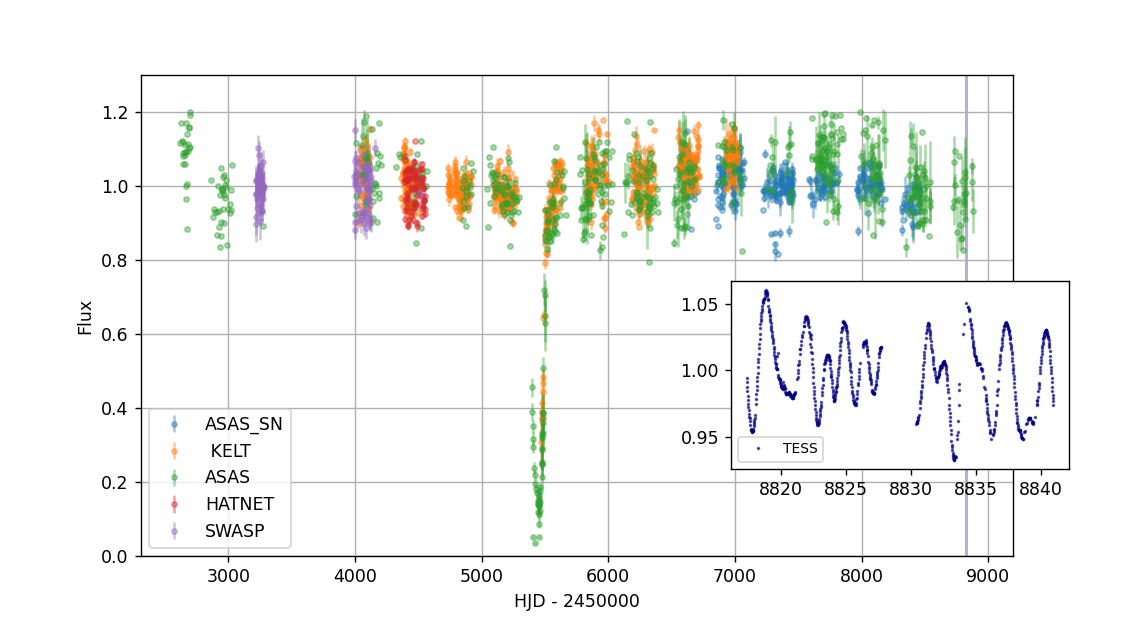

Plotting full light curve by survey
Adding TESS data...


In [25]:
df_full = pd.concat([df_asassn_rs, df_kelt_rs, df_asas_rs, df_hat_rs, df_swasp_rs], join='inner')
    
fig, ax = plt.subplots(1, figsize=(9,5))
print('Plotting full light curve by survey')
for survey in df_full['survey'].unique():
    df_full_survey = df_full[df_full['survey']==survey]
    _ = plot_lc(df_full_survey, ax=ax, label=survey, alpha=0.4)
ax.legend()
ax.set_ylim(0.0, 1.30) 

print('Adding TESS data...')
ax.axvspan(df_tess['HJD'].iloc[0], df_tess['HJD'].iloc[-1], 
            color='navy', alpha=0.3, label='TESS', ec=None)
l, b, h, w = .65, .25, .3, .3
ax2 = fig.add_axes([l, b, w, h])
ax2.plot(df_tess['HJD'], df_tess['flux'], '.', label='TESS', color='navy', alpha=0.6, markersize=2)
ax2.legend(loc='lower left', fontsize=8)